# libraries

In [1]:


# pip install rarfile
import pandas as pd
import matplotlib.pyplot as plt
# from zipfile import ZipFile, Path
from rarfile import RarFile, Path
from PIL import Image
import numpy as np
# import fnmatch

# Binary DATA

### if you have already run these cells, you can skip this section

In [9]:
#reading Images from the zip file and concatenating them as a dataframe also adding related class numbers as a column to it


DF_labels= pd.read_csv("trainLabels.csv") 

with RarFile("ByteToImage.rar") as zipfiles2:

    #the first entry is the zipfile name
    #we'll skip it
    filelist2 = zipfiles2.namelist()[:-1]
    
    images_list = []
    
    for file_name in filelist2:
        m= Image.open(zipfiles2.open(file_name)) 
        images_list.append(pd.DataFrame( np.append((np.asarray(m).reshape(-1,)),DF_labels[DF_labels["Id"] == file_name[12:-4] ]["Class"].values) ).transpose())       
    

df = pd.concat(images_list)

# at first I did a normalization on the data to make them be between 0 and 1 , But with some experiments I realized that
# it's not nessecary and the model works well without any normalization so I commented it out.

# df[df.columns[:-1]]= df[df.columns[:-1]]/256.

df.head()

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024
0,92,92,95,95,93,95,91,87,92,96,...,55,54,54,56,56,56,57,58,55,9
0,124,123,121,125,119,121,127,123,124,124,...,115,121,125,124,120,117,116,121,121,2
0,139,138,136,137,140,139,141,139,141,137,...,99,99,101,100,98,96,97,95,96,9
0,61,53,78,79,77,74,69,67,46,36,...,88,73,69,69,77,87,78,72,81,1
0,110,91,117,128,113,128,140,124,130,130,...,111,105,111,115,105,117,123,117,111,8


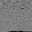

In [10]:
#showing a sample of images
m

In [11]:
#changing the name of the last column
new_col = np.arange(df.columns[-1]).tolist()+["Class"]
df.columns = new_col

In [25]:
df

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,Class
0,92,92,95,95,93,95,91,87,92,96,...,55,54,54,56,56,56,57,58,55,9
0,124,123,121,125,119,121,127,123,124,124,...,115,121,125,124,120,117,116,121,121,2
0,139,138,136,137,140,139,141,139,141,137,...,99,99,101,100,98,96,97,95,96,9
0,61,53,78,79,77,74,69,67,46,36,...,88,73,69,69,77,87,78,72,81,1
0,110,91,117,128,113,128,140,124,130,130,...,111,105,111,115,105,117,123,117,111,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,95,99,96,97,115,118,113,128,121,118,...,116,113,112,111,113,109,108,104,113,4
0,107,141,131,124,110,121,125,128,138,128,...,35,18,19,12,18,18,14,0,21,4
0,135,133,106,131,134,116,118,138,134,120,...,51,50,51,51,49,48,42,49,45,4
0,124,127,126,113,124,128,127,129,120,128,...,60,41,18,34,80,79,83,88,85,4


In [13]:
#count of each class in the dataframe

for i in range(9):
    print("num Total class ",i+1," : ",sum(df["Class"]==i+1))

num Total class  1  :  1533
num Total class  2  :  2478
num Total class  3  :  2942
num Total class  4  :  475
num Total class  5  :  42
num Total class  6  :  751
num Total class  7  :  398
num Total class  8  :  1228
num Total class  9  :  1013


In [26]:
#saving the mentioned Dataframe

filepath = "Binary_DATA_FRAME.csv"
df.to_csv(filepath)  

# SPLIT

In [3]:
#initializing and starting a pyspark session and transform pandas dataframe to spark dataframe

from pyspark.sql import SparkSession #Import the pyspark
from pyspark.conf import SparkConf #Import the SparkConf
from pyspark.context import SparkContext #Import the SparkContext
import time
from pyspark.sql import SparkSession

DF = pd.read_csv("Binary_DATA_FRAME.csv") 
DF = DF.drop('Unnamed: 0', axis=1)
df = DF
conf = SparkConf()
conf.setMaster("local").setAppName("HW2_q2") 

sc = SparkContext.getOrCreate(conf=conf)

#Create PySpark SparkSession
spark= SparkSession.builder.master("local").getOrCreate()

sparkDF=spark.createDataFrame(df) 
# sparkDF.printSchema()
# sparkDF.show()


/home/erfan_wsl/.local/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/home/erfan_wsl/.local/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


In [4]:
spark

In [5]:
#spliting the dataframe to TRAIN,TEST,VALID 

TRAIN,TEST,VALID = sparkDF.randomSplit([0.85,0.1,0.05])

In [6]:
# count of each class in the TRAIN dataframe

TRAIN_pd = TRAIN.select("*").toPandas()
for i in range(9):
    print("num TRAIN class ",i+1," : ",sum(TRAIN_pd["Class"]==i+1))

23/01/01 19:37:50 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
23/01/01 19:37:51 WARN TaskSetManager: Stage 0 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


num TRAIN class  1  :  1315
num TRAIN class  2  :  2097
num TRAIN class  3  :  2539
num TRAIN class  4  :  395
num TRAIN class  5  :  39
num TRAIN class  6  :  653
num TRAIN class  7  :  335
num TRAIN class  8  :  1041
num TRAIN class  9  :  867


In [7]:
# count of each class in the TEST dataframe

TEST_pd = TEST.select("*").toPandas()
for i in range(9):
    print("num TEST class ",i+1," : ",sum(TEST_pd["Class"]==i+1))

23/01/01 19:38:06 WARN TaskSetManager: Stage 1 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


num TEST class  1  :  139
num TEST class  2  :  248
num TEST class  3  :  278
num TEST class  4  :  42
num TEST class  5  :  2
num TEST class  6  :  72
num TEST class  7  :  40
num TEST class  8  :  127
num TEST class  9  :  89


In [8]:
#count of each class in the VALID dataframe

VALID_pd = VALID.select("*").toPandas()
for i in range(9):
    print("num VALID class ",i+1," : ",sum(VALID_pd["Class"]==i+1))

23/01/01 19:38:14 WARN TaskSetManager: Stage 2 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


num VALID class  1  :  79
num VALID class  2  :  133
num VALID class  3  :  125
num VALID class  4  :  38
num VALID class  5  :  1
num VALID class  6  :  26
num VALID class  7  :  23
num VALID class  8  :  60
num VALID class  9  :  57


In [9]:
VALID_pd

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,Class
0,0,13,21,30,35,7,5,0,2,0,...,52,35,36,40,42,42,42,44,42,1
1,30,42,47,62,60,37,41,37,38,40,...,97,89,93,95,88,71,73,78,75,1
2,37,42,63,46,63,48,44,56,52,58,...,65,67,66,65,62,64,64,67,66,1
3,45,43,42,45,44,48,36,39,40,37,...,83,74,66,74,75,80,79,76,57,1
4,45,51,50,58,64,57,59,55,48,43,...,83,85,80,83,78,79,80,65,63,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537,152,153,151,151,150,152,152,148,148,147,...,103,99,106,106,107,103,106,103,103,2
538,153,138,138,155,160,165,148,159,139,135,...,153,0,90,168,0,53,160,0,38,7
539,164,131,149,149,171,152,147,144,138,133,...,72,12,0,38,17,7,31,92,118,7
540,164,159,146,166,169,159,170,160,173,167,...,36,36,0,0,0,0,0,1,14,8


In [10]:
# TRAIN,TEST,VALID shuffling

from pyspark.sql.functions import rand 

TRAIN = TRAIN.orderBy(rand())
TEST = TEST.orderBy(rand())
VALID = VALID.orderBy(rand())

# Random Forest

In [11]:

print("Training Dataset Count: " + str(TRAIN.count()))
print("Test Dataset Count: " + str(TEST.count()))
print("Validation Dataset Count: " + str(VALID.count()))

23/01/01 19:38:38 WARN TaskSetManager: Stage 3 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


Training Dataset Count: 9281
23/01/01 19:38:40 WARN TaskSetManager: Stage 6 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


Test Dataset Count: 1037
23/01/01 19:38:42 WARN TaskSetManager: Stage 9 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


Validation Dataset Count: 542


In [12]:
#adding a features column which contains all the columns as a single list, except labels column, to all dataframes

from pyspark.ml.feature import StringIndexer, VectorAssembler


input_cols=VALID_pd.columns[:-1]
output_cols="features"

assembler = VectorAssembler(inputCols=input_cols.to_list(), outputCol=output_cols)
TRAIN = assembler.transform(TRAIN)
TEST = assembler.transform(TEST)
VALID = assembler.transform(VALID)



In [13]:
# you can see the last column here

VALID.select("*").toPandas()


23/01/01 19:39:04 WARN TaskSetManager: Stage 12 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 19:39:07 WARN TaskSetManager: Stage 13 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


,0,1,2,3,4,5,6,7,8,9,...,1016,1017,1018,1019,1020,1021,1022,1023,Class,features
0,118,122,125,124,117,120,121,126,124,128,...,127,129,128,130,130,126,122,120,2,"[118.0, 122.0, 125.0, 124.0, 117.0, 120.0, 121..."
1,131,131,131,132,132,131,133,135,136,136,...,112,107,104,110,108,105,103,109,2,"[131.0, 131.0, 131.0, 132.0, 132.0, 131.0, 133..."
2,101,93,97,93,88,99,102,102,95,85,...,61,62,71,62,48,46,43,41,1,"[101.0, 93.0, 97.0, 93.0, 88.0, 99.0, 102.0, 1..."
3,121,126,122,114,113,122,108,108,120,99,...,56,68,70,62,59,73,66,62,2,"[121.0, 126.0, 122.0, 114.0, 113.0, 122.0, 108..."
4,107,111,109,111,112,106,111,114,114,111,...,108,109,105,107,113,109,115,116,2,"[107.0, 111.0, 109.0, 111.0, 112.0, 106.0, 111..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537,127,131,129,129,124,127,131,127,128,131,...,75,73,77,75,75,73,76,77,6,"[127.0, 131.0, 129.0, 129.0, 124.0, 127.0, 131..."
538,111,108,108,101,101,102,105,102,101,113,...,121,124,123,128,131,132,128,131,3,"[111.0, 108.0, 108.0, 101.0, 101.0, 102.0, 105..."
539,118,122,133,117,113,118,131,128,119,130,...,118,117,122,121,126,120,121,119,3,"[118.0, 122.0, 133.0, 117.0, 113.0, 118.0, 131..."
540,133,119,115,126,130,132,124,129,124,132,...,131,128,114,118,129,130,117,116,3,"[133.0, 119.0, 115.0, 126.0, 130.0, 132.0, 124..."


# changing the maxDepth

In [14]:
#building and training a random forest classifier with numTrees=10, maxDepth=3,4,5,6,7,8

from pyspark.ml.classification import RandomForestClassifier
predictions = []
for dep in range(3,9):
    rf = RandomForestClassifier(numTrees=10, maxDepth= dep ,featuresCol = "features", labelCol = "Class")
    rfModel = rf.fit(TRAIN)
    predictions.append( rfModel.transform(TEST) )

predictions[0].select("Class", "prediction").show(10)




23/01/01 19:41:48 WARN TaskSetManager: Stage 16 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 19:41:51 WARN TaskSetManager: Stage 17 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 19:42:05 WARN TaskSetManager: Stage 18 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 19:42:07 WARN TaskSetManager: Stage 21 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 19:42:08 WARN TaskSetManager: Stage 22 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 19:42:26 WARN TaskSetManager: Stage 39 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 19:42:27 WARN TaskSetManager: Stage 40 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 19:42:48 WARN TaskSetManager: Stage 41 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 19:42:49 WARN TaskSetManager: Stage 42 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 19:43:02 WARN TaskSetManager: Stage 43 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 19:43:03 WARN TaskSetManager: Stage 46 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 19:43:05 WARN TaskSetManager: Stage 47 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 19:43:16 WARN TaskSetManager: Stage 67 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 19:43:17 WARN TaskSetManager: Stage 68 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 19:43:35 WARN TaskSetManager: Stage 69 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 19:43:37 WARN TaskSetManager: Stage 70 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 19:43:50 WARN TaskSetManager: Stage 71 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 19:43:51 WARN TaskSetManager: Stage 74 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 19:43:53 WARN TaskSetManager: Stage 75 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 19:44:05 WARN TaskSetManager: Stage 98 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 19:44:06 WARN TaskSetManager: Stage 99 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 19:44:23 WARN TaskSetManager: Stage 100 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 19:44:25 WARN TaskSetManager: Stage 101 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 19:44:37 WARN TaskSetManager: Stage 102 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 19:44:39 WARN TaskSetManager: Stage 105 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 19:44:40 WARN TaskSetManager: Stage 106 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 19:44:53 WARN TaskSetManager: Stage 132 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 19:44:54 WARN TaskSetManager: Stage 133 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 19:45:11 WARN TaskSetManager: Stage 134 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 19:45:12 WARN TaskSetManager: Stage 135 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 19:45:25 WARN TaskSetManager: Stage 136 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 19:45:27 WARN TaskSetManager: Stage 139 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 19:45:28 WARN TaskSetManager: Stage 140 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 19:45:40 WARN DAGScheduler: Broadcasting large task binary with size 1079.3 KiB


23/01/01 19:45:42 WARN TaskSetManager: Stage 169 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 19:45:45 WARN TaskSetManager: Stage 170 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 19:46:09 WARN TaskSetManager: Stage 171 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 19:46:11 WARN TaskSetManager: Stage 172 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 19:46:28 WARN TaskSetManager: Stage 173 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 19:46:30 WARN TaskSetManager: Stage 176 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 19:46:32 WARN TaskSetManager: Stage 177 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 19:46:44 WARN DAGScheduler: Broadcasting large task binary with size 1079.3 KiB
23/01/01 19:46:45 WARN DAGScheduler: Broadcasting large task binary with size 1256.3 KiB


23/01/01 19:46:48 WARN TaskSetManager: Stage 209 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 19:46:50 WARN TaskSetManager: Stage 210 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 19:46:53 WARN TaskSetManager: Stage 211 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 19:46:55 WARN TaskSetManager: Stage 212 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


+-----+----------+
|Class|prediction|
+-----+----------+
|    2|       3.0|
|    2|       2.0|
|    1|       1.0|
|    1|       1.0|
|    2|       2.0|
|    1|       4.0|
|    7|       1.0|
|    3|       3.0|
|    8|       8.0|
|    2|       2.0|
+-----+----------+
only showing top 10 rows



In [15]:
# calculating the accuracy 

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
accuracy=[]
for p in predictions:
    evaluator = MulticlassClassificationEvaluator(labelCol="Class", predictionCol="prediction")
    accuracy.append(evaluator.evaluate(p))
    
print("Accuracy = %s" % (accuracy))
# print("Test Error = %s" % (1.0 - accuracy))




23/01/01 20:03:01 WARN TaskSetManager: Stage 215 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 20:03:03 WARN TaskSetManager: Stage 216 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 20:03:05 WARN TaskSetManager: Stage 220 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 20:03:07 WARN TaskSetManager: Stage 221 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 20:03:09 WARN TaskSetManager: Stage 225 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 20:03:11 WARN TaskSetManager: Stage 226 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 20:03:13 WARN TaskSetManager: Stage 230 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 20:03:14 WARN TaskSetManager: Stage 231 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 20:03:16 WARN TaskSetManager: Stage 235 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 20:03:18 WARN TaskSetManager: Stage 236 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 20:03:20 WARN TaskSetManager: Stage 240 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 20:03:22 WARN TaskSetManager: Stage 241 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


Accuracy = [0.6489341263539413, 0.7981002363107618, 0.8329948886868613, 0.8716081250208865, 0.9025088943788263, 0.9124999524000985]


In [16]:
DEPTH_TREES = [3, 4, 5, 6, 7, 8]

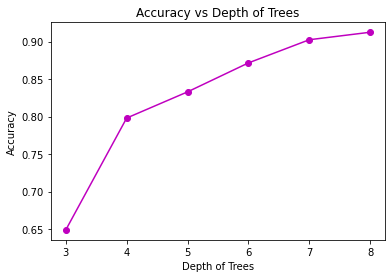

In [18]:
# plotting the the accuracy of models for each DEPTH_trees in experiments

plt.plot(DEPTH_TREES, accuracy,"mo-")
plt.title("Accuracy vs Depth of Trees")
plt.xlabel("Depth of Trees")
plt.ylabel("Accuracy")
plt.savefig("Accuracy vs DEPTH_trees.png")

# so according to this result we choose DEPTH_trees = 8

In [22]:
# choosing the best_depth
best_depth = DEPTH_TREES[np.argmax(accuracy)]

In [39]:
# # obtaining the confusion matrix

# from pyspark.mllib.evaluation import MulticlassMetrics
# from pyspark.sql.types import FloatType
# import pyspark.sql.functions as F

# preds_and_labels = predictions.select(['prediction','Class']).withColumn('Class', F.col('Class').cast(FloatType())).orderBy('prediction')
# preds_and_labels = preds_and_labels.select(['prediction','Class'])
# metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
# print(metrics.confusionMatrix().toArray())

23/01/01 18:09:30 WARN TaskSetManager: Stage 109 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 18:09:32 WARN TaskSetManager: Stage 110 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 18:09:35 WARN DAGScheduler: Broadcasting large task binary with size 1123.0 KiB


23/01/01 18:09:36 WARN DAGScheduler: Broadcasting large task binary with size 1123.0 KiB


/home/erfan_wsl/.local/lib/python3.10/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


23/01/01 18:09:37 WARN DAGScheduler: Broadcasting large task binary with size 1258.3 KiB
23/01/01 18:09:37 WARN DAGScheduler: Broadcasting large task binary with size 1267.9 KiB
[[136.   2.   0.   1.   0.   2.   2.   0.   9.]
 [ 11. 233.   1.   0.   0.   2.   0.   0.   9.]
 [  0.   0. 329.   0.   0.   0.   0.   0.   0.]
 [  3.   0.   4.  35.   0.   0.   0.   0.   0.]
 [  3.   0.   0.   1.   0.   0.   0.   0.   0.]
 [ 19.   3.   0.   0.   0.  29.   0.   0.  18.]
 [  0.   0.   0.   0.   0.   0.  31.   0.   4.]
 [ 12.   3.   0.   2.   0.   1.   1.  85.   7.]
 [  7.   6.   2.   7.   0.   4.   0.   0.  79.]]


In [40]:
# # Overall statistics
# # calculating precision, recall, f1Score, True Positive Rate, False Positive Rate
# # mean of these metrics have been calculated just for num_trees=30 becuase it has the best result in accuracy

# precision = []
# recall = []
# f1Score = []
# tpr = []
# fpr = []

# for i in range(9):
#     precision.append(metrics.precision(i+1.) )
#     recall.append(metrics.recall(i+1.) )
#     f1Score.append(metrics.fMeasure(i+1.) )
#     tpr.append(metrics.truePositiveRate(i+1.) )
#     fpr.append(metrics.falsePositiveRate(i+1.) )
# print("Summary Stats")
# print("\nPrecision = %s" % precision)
# print("\nRecall = %s" % recall)
# print("\nF1 Score = %s" % f1Score)
# print("\nTrue Positive Rate = %s" % tpr)
# print("\nFalse Positive Rate = %s" % fpr)




Summary Stats

Precision = [0.7120418848167539, 0.9433198380566802, 0.9791666666666666, 0.7608695652173914, 0.0, 0.7631578947368421, 0.9117647058823529, 1.0, 0.626984126984127]

Recall = [0.8947368421052632, 0.91015625, 1.0, 0.8333333333333334, 0.0, 0.42028985507246375, 0.8857142857142857, 0.7657657657657657, 0.7523809523809524]

F1 Score = [0.793002915451895, 0.9264413518886679, 0.9894736842105264, 0.7954545454545455, 0.0, 0.5420560747663552, 0.8985507246376812, 0.8673469387755102, 0.683982683982684]

True Positive Rate = [0.8947368421052632, 0.91015625, 1.0, 0.8333333333333334, 0.0, 0.42028985507246375, 0.8857142857142857, 0.7657657657657657, 0.7523809523809524]

False Positive Rate = [0.05783385909568875, 0.01652892561983471, 0.00904392764857881, 0.010367577756833177, 0.0, 0.008704061895551257, 0.0028089887640449437, 0.0, 0.047094188376753505]


In [41]:
# # calculaing the means for all the above metrics 

# precision_m = np.mean(precision)
# recall_m = np.mean(recall)
# f1Score_m = np.mean(f1Score)
# tpr_m = np.mean(tpr)
# fpr_m = np.mean(fpr)

# print("Summary mean Stats")
# print("\nPrecision = %s" % precision_m)
# print("\nRecall = %s" % recall_m)
# print("\nF1 Score = %s" % f1Score_m)
# print("\nTrue Positive Rate = %s" % tpr_m)
# print("\nFalse Positive Rate = %s" % fpr_m)




Summary mean Stats

Precision = 0.7441449647067571

Recall = 0.718041920485785

F1 Score = 0.7218121021297628

True Positive Rate = 0.718041920485785

False Positive Rate = 0.016931281017476128


# changing the Max bins

In [26]:
#building and training a random forest classifier with numTrees=10, maxDepth=best_depth, Max bins=4, 8, 16, 32

from pyspark.ml.classification import RandomForestClassifier
predictions = []
BINS = [4,8,16,32]
for bins in BINS:
    rf = RandomForestClassifier(numTrees=10, maxDepth= best_depth , maxBins=bins ,featuresCol = "features", labelCol = "Class")
    rfModel = rf.fit(TRAIN)
    predictions.append( rfModel.transform(TEST) )

predictions[0].select("Class", "prediction").show(10)




23/01/01 20:20:59 WARN TaskSetManager: Stage 429 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 20:21:01 WARN TaskSetManager: Stage 430 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 20:21:14 WARN TaskSetManager: Stage 431 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 20:21:16 WARN TaskSetManager: Stage 434 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 20:21:17 WARN TaskSetManager: Stage 435 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 20:21:30 WARN DAGScheduler: Broadcasting large task binary with size 1187.8 KiB
23/01/01 20:21:31 WARN TaskSetManager: Stage 467 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 20:21:32 WARN TaskSetManager: Stage 468 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 20:21:49 WARN TaskSetManager: Stage 469 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 20:21:51 WARN TaskSetManager: Stage 470 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 20:22:04 WARN TaskSetManager: Stage 471 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 20:22:06 WARN TaskSetManager: Stage 474 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 20:22:08 WARN TaskSetManager: Stage 475 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 20:22:20 WARN DAGScheduler: Broadcasting large task binary with size 1194.4 KiB
23/01/01 20:22:21 WARN TaskSetManager: Stage 507 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 20:22:22 WARN TaskSetManager: Stage 508 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 20:22:40 WARN TaskSetManager: Stage 509 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 20:22:42 WARN TaskSetManager: Stage 510 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 20:22:55 WARN TaskSetManager: Stage 511 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 20:22:57 WARN TaskSetManager: Stage 514 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 20:22:59 WARN TaskSetManager: Stage 515 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 20:23:11 WARN DAGScheduler: Broadcasting large task binary with size 1190.2 KiB
23/01/01 20:23:12 WARN TaskSetManager: Stage 547 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 20:23:14 WARN TaskSetManager: Stage 548 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 20:23:32 WARN TaskSetManager: Stage 549 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 20:23:34 WARN TaskSetManager: Stage 550 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 20:23:48 WARN TaskSetManager: Stage 551 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 20:23:50 WARN TaskSetManager: Stage 554 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 20:23:51 WARN TaskSetManager: Stage 555 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 20:24:04 WARN DAGScheduler: Broadcasting large task binary with size 1079.3 KiB
23/01/01 20:24:05 WARN DAGScheduler: Broadcasting large task binary with size 1256.3 KiB


23/01/01 20:24:07 WARN TaskSetManager: Stage 587 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 20:24:09 WARN TaskSetManager: Stage 588 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 20:24:11 WARN TaskSetManager: Stage 589 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 20:24:13 WARN TaskSetManager: Stage 590 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 20:24:15 WARN DAGScheduler: Broadcasting large task binary with size 1026.9 KiB
+-----+----------+
|Class|prediction|
+-----+----------+
|    2|       2.0|
|    2|       2.0|
|    1|       1.0|
|    1|       1.0|
|    2|       2.0|
|    1|       1.0|
|    7|       7.0|
|    3|       3.0|
|    8|       8.0|
|    2|       2.0|
+-----+----------+
only showing top 10 rows



In [27]:
# calculating the accuracy 

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
accuracy=[]
for p in predictions:
    evaluator = MulticlassClassificationEvaluator(labelCol="Class", predictionCol="prediction")
    accuracy.append(evaluator.evaluate(p))
    
print("Accuracy = %s" % (accuracy))
# print("Test Error = %s" % (1.0 - accuracy))




23/01/01 20:24:16 WARN TaskSetManager: Stage 593 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 20:24:18 WARN TaskSetManager: Stage 594 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 20:24:20 WARN DAGScheduler: Broadcasting large task binary with size 1044.0 KiB


23/01/01 20:24:20 WARN TaskSetManager: Stage 598 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 20:24:22 WARN TaskSetManager: Stage 599 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 20:24:23 WARN DAGScheduler: Broadcasting large task binary with size 1019.0 KiB


23/01/01 20:24:24 WARN TaskSetManager: Stage 603 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 20:24:25 WARN TaskSetManager: Stage 604 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 20:24:28 WARN TaskSetManager: Stage 608 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


23/01/01 20:24:30 WARN TaskSetManager: Stage 609 contains a task of very large size (21780 KiB). The maximum recommended task size is 1000 KiB.


Accuracy = [0.9111364303901102, 0.9106564637358802, 0.9124603107791924, 0.9124999524000985]


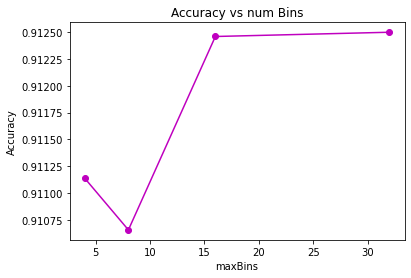

In [28]:
# plotting the the accuracy of models for each maxBins in experiments

plt.plot(BINS, accuracy,"mo-")
plt.title("Accuracy vs num Bins")
plt.xlabel("maxBins")
plt.ylabel("Accuracy")
plt.savefig("Accuracy vs maxBins.png")
